In [20]:
import random
import requests
import json
import pandas as pd
from bs4 import BeautifulSoup
from lxml import etree

In [131]:
# 参考资料：
# request框架：https://www.jb51.net/article/232560.htm
# retry装饰器：https://www.jianshu.com/p/51913f069a27
# 反反爬-增加header：https://www.jb51.net/python/285238abi.htm#_label1

from retrying import retry
@retry(stop_max_attempt_number=2000)
def getHtml(url):
    user_agent = random.choice(USER_AGENTS)
    headers = {
        "Host":"www.echinagov.com",
        'User-Agent': user_agent
    }
    try:
        response = requests.get(url, headers=headers)
        response.encoding = response.apparent_encoding
        #print(response.url)
        text = response.text
        return text
    except:
        print("爬取失败!")
        raise Exception("爬取失败，重试...")

In [3]:
USER_AGENTS = [
    "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36",
    "Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.75.14 (KHTML, like Gecko) Version/7.0.3 Safari/537.75.14",
    "Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.2; Win64; x64; Trident/6.0)",
    'Mozilla/5.0 (Windows; U; Windows NT 5.1; it; rv:1.8.1.11) Gecko/20071127 Firefox/2.0.0.11',
    'Opera/9.25 (Windows NT 5.1; U; en)',
    'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1; .NET CLR 1.1.4322; .NET CLR 2.0.50727)',
    'Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.5 (like Gecko) (Kubuntu)',
    'Mozilla/5.0 (X11; U; Linux i686; en-US; rv:1.8.0.12) Gecko/20070731 Ubuntu/dapper-security Firefox/1.5.0.12',
    'Lynx/2.8.5rel.1 libwww-FM/2.14 SSL-MM/1.4.1 GNUTLS/1.2.9',
    "Mozilla/5.0 (X11; Linux i686) AppleWebKit/535.7 (KHTML, like Gecko) Ubuntu/11.04 Chromium/16.0.912.77 Chrome/16.0.912.77 Safari/535.7",
    "Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:10.0) Gecko/20100101 Firefox/10.0 "
]

**爬虫测试：从单个网页开始调试**

In [4]:
url_test = "https://www.echinagov.com/awardsSearch?p0=&p1=&page=1"

In [9]:
test1 = getHtml(url_test)

In [10]:
test1

'<!DOCTYPE html>\r\n<html lang="zh-CN">\r\n<head>\r\n<meta charset="UTF-8" />\r\n<meta http-equiv="X-UA-Compatible" content="IE=Edge" />\r\n<meta name="viewport" />\r\n<link rel="stylesheet" href="/template/1/echinagov/_files/fonts/Font-Awesome-master4.6.3/css/font-awesome.min.css" />\r\n<link rel="stylesheet" href="/template/1/echinagov/_files/styles/reset.css" />\r\n<link rel="stylesheet" href="/template/1/echinagov/_files/styles/style.min.css" />\r\n<script type="text/javascript" src="/template/1/echinagov/_files/dependencies/js/jquery.js"></script> \r\n<script type="text/javascript" src="/template/1/echinagov/_files/layer/layer.js"></script>\r\n<script type = "text/javascript" language = "javascript" >  \r\n             //平台、设备和操作系统   \r\n             var system = {  \r\n                 win: false,  \r\n                 mac: false,  \r\n                 xll: false,  \r\n                 ipad: false  \r\n             };  \r\n             //检测平台   \r\n             var p = navigator.

In [13]:
soup_test = BeautifulSoup(test1,'lxml')

In [14]:
soup_test

<!DOCTYPE html>
<html lang="zh-CN">
<head>
<meta charset="utf-8"/>
<meta content="IE=Edge" http-equiv="X-UA-Compatible"/>
<meta name="viewport"/>
<link href="/template/1/echinagov/_files/fonts/Font-Awesome-master4.6.3/css/font-awesome.min.css" rel="stylesheet"/>
<link href="/template/1/echinagov/_files/styles/reset.css" rel="stylesheet"/>
<link href="/template/1/echinagov/_files/styles/style.min.css" rel="stylesheet"/>
<script src="/template/1/echinagov/_files/dependencies/js/jquery.js" type="text/javascript"></script>
<script src="/template/1/echinagov/_files/layer/layer.js" type="text/javascript"></script>
<script language="javascript" type="text/javascript">  
             //平台、设备和操作系统   
             var system = {  
                 win: false,  
                 mac: false,  
                 xll: false,  
                 ipad: false  
             };  
             //检测平台   
             var p = navigator.platform;  
             system.win = p.indexOf("Win") == 0;  
          

BeautifulSoup帮助我们将网页内容解析得更方便理解

可以看到，这个网站的源码提供的信息还是比较丰富的

比如说：

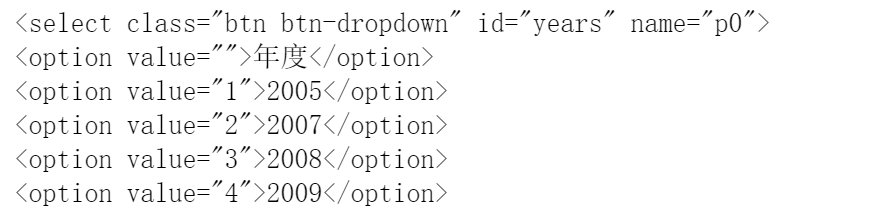

这块代码告诉我们：p0是年度的索引，取1时代表访问2005年的信息，取2是代表访问2007年的信息，其他以此类推。

再比如说：

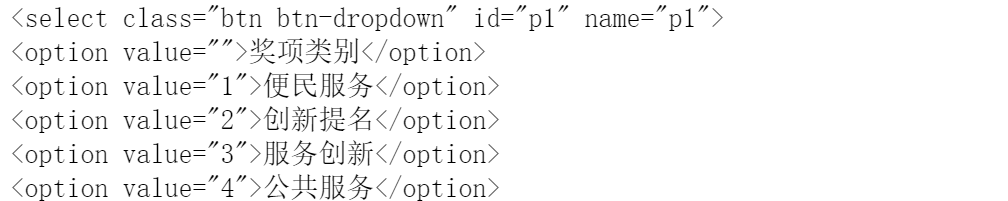

类似地，这段代码则向我们透露：p1是类别的索引，取1时代表访问便民服务的信息，其他以此类推。

回想一下我们爬虫的网址：

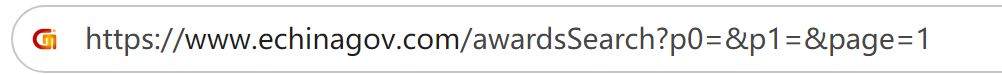

由此，可以很容易地理解这个网站的结构。当我们调整p0和p1时，理论上可以访问任意年份、任意主题的数据。page也很好理解，是指第几页。

当我们不填入p0和p1的值时，也可以爬取到网页的数据，且可以发现，这个数据不区分年份和主题。换言之，按照现在的网址，我们其实已经获取了历年所有主题的获奖信息，只是这些信息被分布在了不同page上。

如果你是经验丰富的老手，你可能会试试添加像size、pagesize之类的参数，用来调整每页显示信息的数量。

不过很遗憾，这个网页似乎没有这种参数。但也不打紧，只需要简单一个循环，即可把数据获取下来。

以上，我们清楚了整个网页的构造，也明确了爬虫思路，即调整page参数，逐页爬取。下面的问题就是，**如何获取网页上的信息。**

这里，我们主要采用XPATH表达来提取Html上的信息。

XPATH和正则表达都是提取网页信息的主要方法。从学习难度上来说，XPATH更容易入门，正则表达略抽象，也需要记住一些符号和含义，入门略难。

日常爬取网页时，用XPATH能解决90%的问题，即便不学习正则表达，也足够应付大多数情况。

但面对实打实的文本分析的项目，那还得学习和使用正则表达。

对上述两种方法感兴趣的读者，可以参考下面的资料：https://www.zhihu.com/question/431037241/answer/3200046586

下面着重介绍XPATH方法。

首先，你需要按照一个Chrome插件——XPath Helper

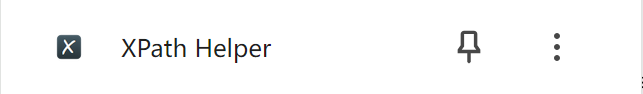

下面，打开url_test网址，然后点击F12，召唤出开发者工具，然后用鼠标选中表格(先点1，再把鼠标移到2)，复制对应的elements（鼠标选中3中对应的Html语句，然后右键复制，记得复制为Xpath格式）。

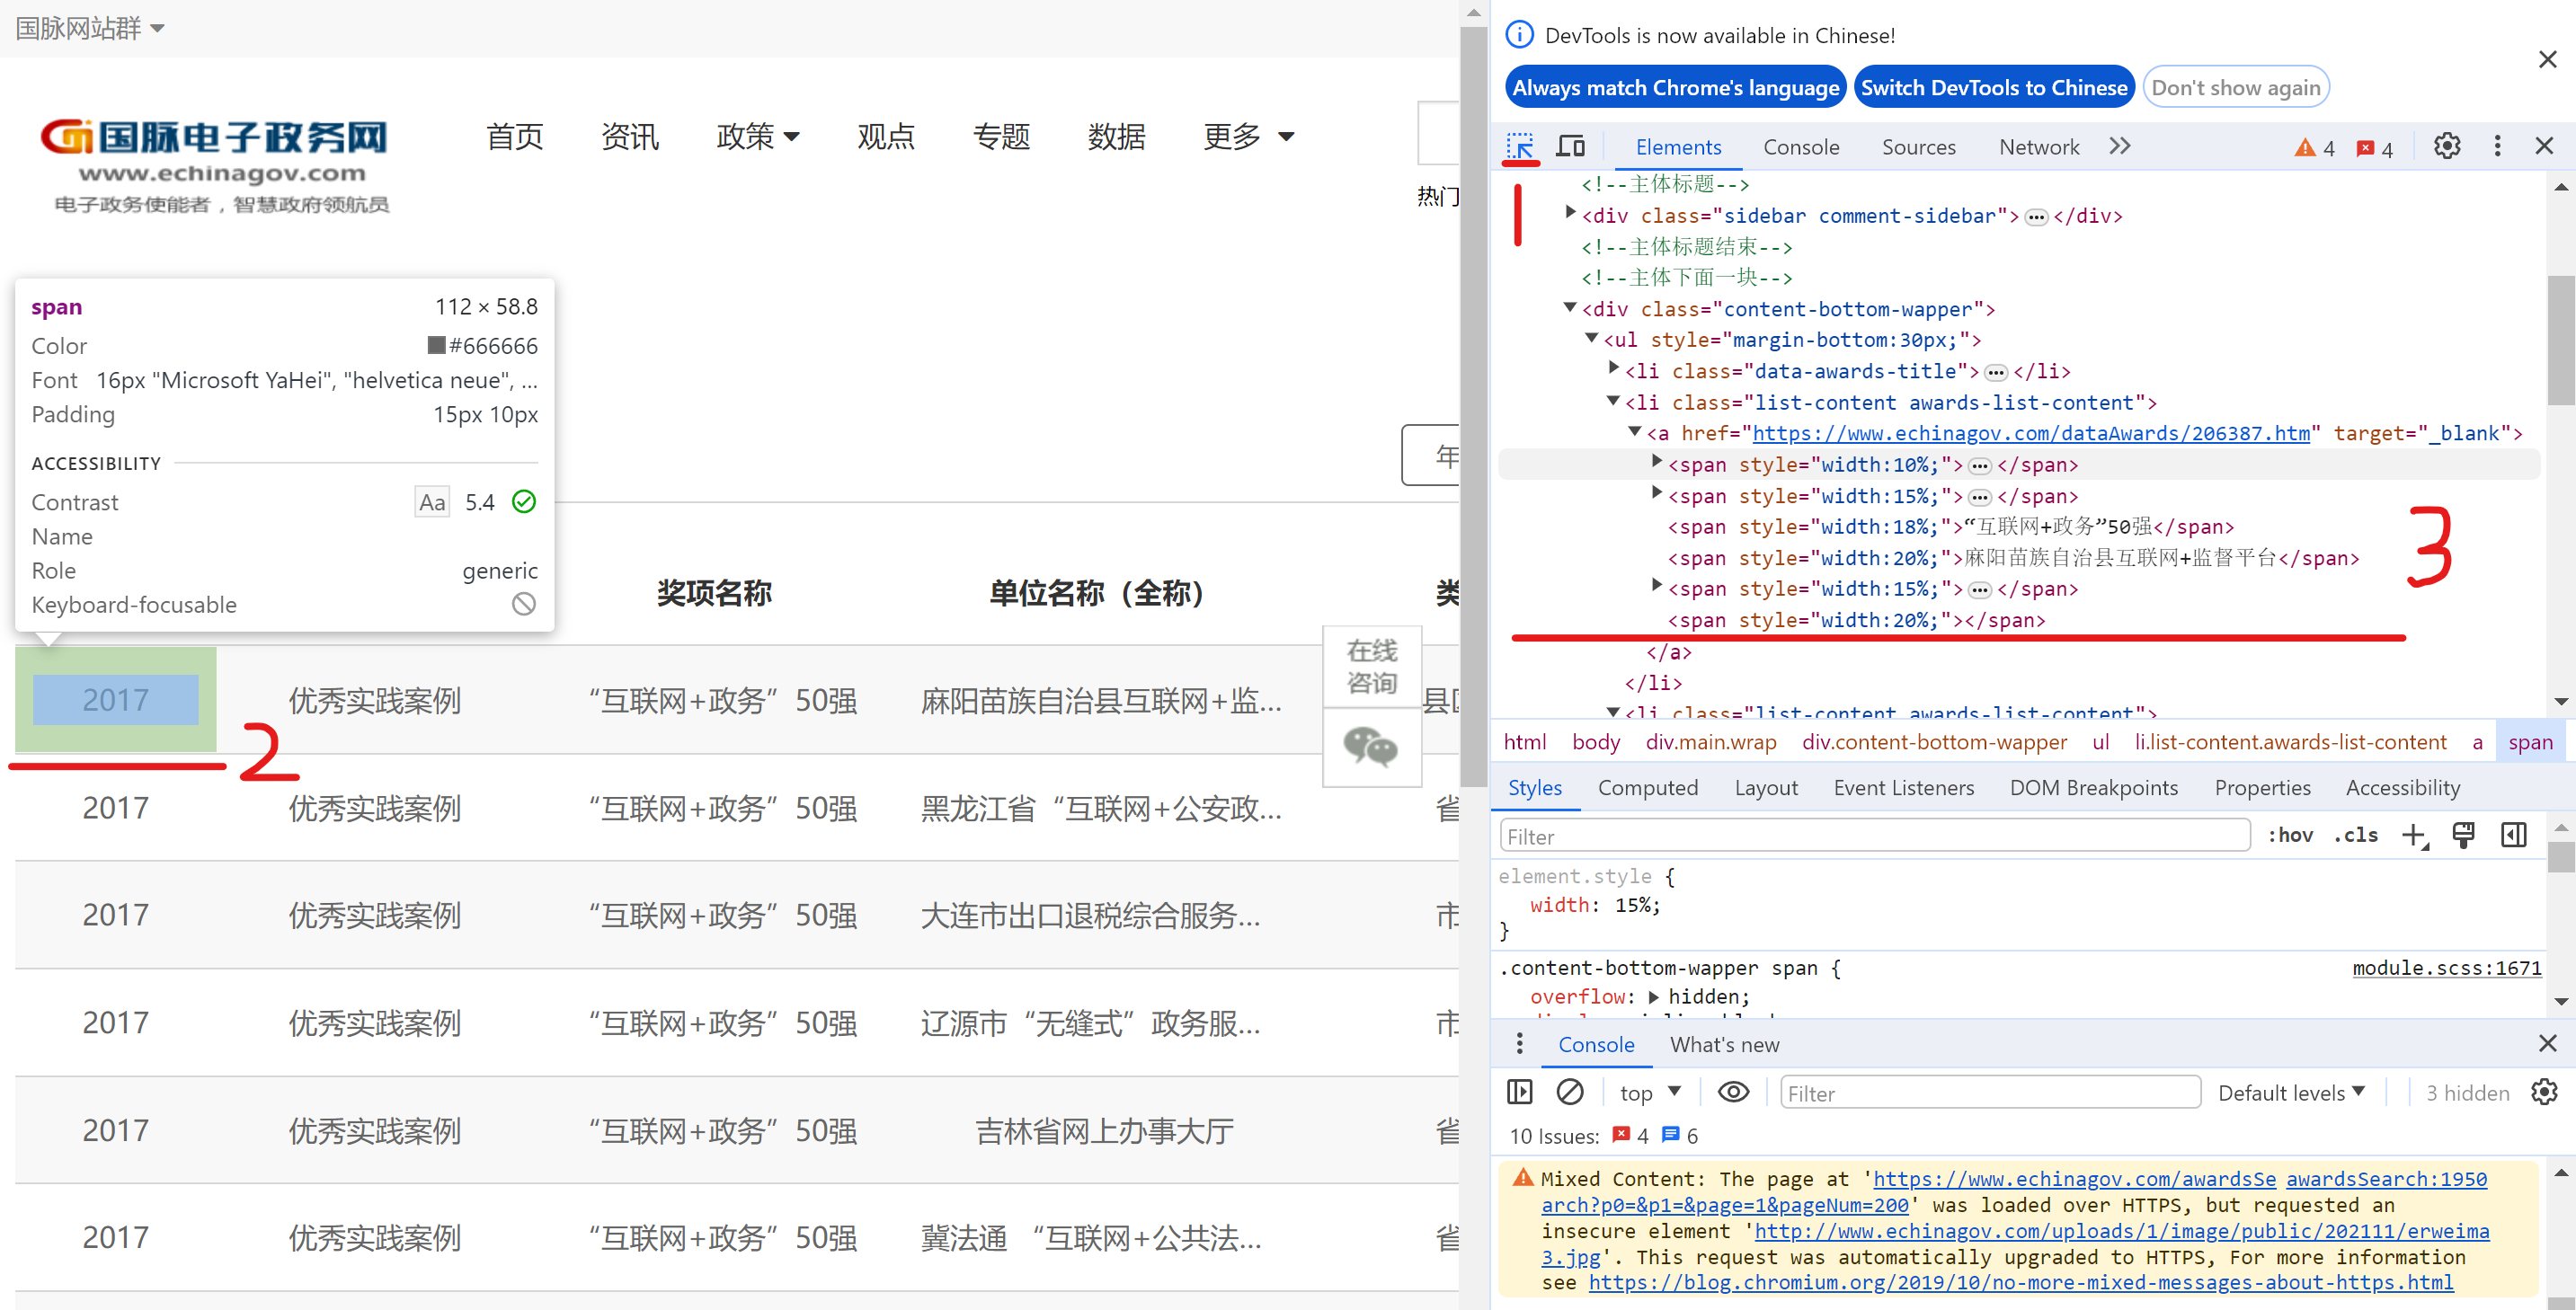

然后把Xpath语句复制到Xpath Helper插件的黑色框框处，然后调整我们的Xpath语句，直到可以提取出我们想要的数据。

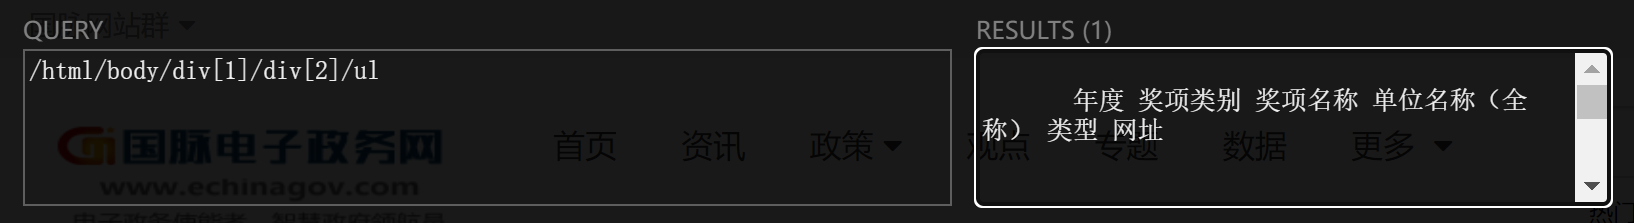

In [92]:
# 调试过程中，也可以按住shift然后鼠标移动到所需标签处，Xpath Helper会自动显示路径
web = etree.HTML(test1).xpath("/html/body/div[@class='main wrap']/div[@class='content-bottom-wapper']/ul/li[@class='list-content awards-list-content']/a/span") 

In [106]:
web

[<Element span at 0x2d37e23f480>,
 <Element span at 0x2d37e23ff80>,
 <Element span at 0x2d37e23f400>,
 <Element span at 0x2d37e23f880>,
 <Element span at 0x2d37e23ea40>,
 <Element span at 0x2d37e23fbc0>,
 <Element span at 0x2d37e23eec0>,
 <Element span at 0x2d37e23e440>,
 <Element span at 0x2d37e23ec00>,
 <Element span at 0x2d37e23ee40>,
 <Element span at 0x2d37e23eb00>,
 <Element span at 0x2d37e23f980>,
 <Element span at 0x2d37e23e940>,
 <Element span at 0x2d37e23e8c0>,
 <Element span at 0x2d37e23db00>,
 <Element span at 0x2d37e23e640>,
 <Element span at 0x2d37e23e580>,
 <Element span at 0x2d37e23e600>,
 <Element span at 0x2d37e23e780>,
 <Element span at 0x2d37e23e100>,
 <Element span at 0x2d37e23fec0>,
 <Element span at 0x2d37e23d340>,
 <Element span at 0x2d37e23c200>,
 <Element span at 0x2d37e23c400>,
 <Element span at 0x2d37e23c5c0>,
 <Element span at 0x2d37e23c880>,
 <Element span at 0x2d37e23c900>,
 <Element span at 0x2d37e23c840>,
 <Element span at 0x2d37e23ca40>,
 <Element span

In [112]:
str(web[5].text)

'None'

In [113]:
# 对提取出的文本数据进行清洗
[str(i.text).replace('\r\n',"").replace(' ',"") for i in web]

['2017',
 '优秀实践案例',
 '“互联网+政务”50强',
 '麻阳苗族自治县互联网+监督平台',
 '县区级',
 'None',
 '2017',
 '优秀实践案例',
 '“互联网+政务”50强',
 '黑龙江省“互联网+公安政务服务”平台',
 '省级',
 'None',
 '2017',
 '优秀实践案例',
 '“互联网+政务”50强',
 '大连市出口退税综合服务平台',
 '市级',
 'None',
 '2017',
 '优秀实践案例',
 '“互联网+政务”50强',
 '辽源市“无缝式”政务服务模式',
 '市级',
 'None',
 '2017',
 '优秀实践案例',
 '“互联网+政务”50强',
 '吉林省网上办事大厅',
 '省级',
 'None',
 '2017',
 '优秀实践案例',
 '“互联网+政务”50强',
 '冀法通“互联网+公共法律服务”平台',
 '省级',
 'None',
 '2017',
 '优秀实践案例',
 '“互联网+政务”50强',
 '鄂州“政务一网通”服务模式',
 '市级',
 'None',
 '2017',
 '优秀实践案例',
 '“互联网+政务”50强',
 '“智慧武昌”城市公共信息平台',
 '市级',
 'None',
 '2017',
 '优秀实践案例',
 '“互联网+政务”50强',
 '宜昌“互联网+就业服务”政务服务平台',
 '市级',
 'None',
 '2017',
 '优秀实践案例',
 '“互联网+政务”50强',
 '武汉市社会服务与管理信息系统',
 '市级',
 'None']

So far so good！这个数据已经差不多变成我们想要的格式了！最后再做一点处理就成了。

为处理上述数据，这里为大家介绍一个小技巧：

In [74]:
# 考虑到以后还会遇到类似的情况，抱着一劳永逸的想法，我们不妨定义一个简单的函数，用来专门解决本例中我们遇到的格式整理问题

def ls2df(ls,column_num:int,column_names=[]):
    '''
    input
    ------
    ls: a list with format like ['a1','a2','a3','b1','b2','b3',...]
    column_num: the number of column of your table
    column_names: the name of column of your table
    '''
    import pandas as pd
    if len(ls)%column_num==0:
        if column_names==[]:
            df = pd.DataFrame()
            for i in range(column_num):
                df['col'+str(i)] = [ls[j] for j in range(i,len(ls),column_num)]
            return df
        else:
            if column_num==len(column_names):
                df = pd.DataFrame()
                for i in range(column_num):
                    df[column_names[i]] = [ls[j] for j in range(i,len(ls),column_num)]
                return df
            else:
                print("Error!!\nThe numbers of columan and its name are not matched!")
    else:
        print("Error!!\nThe structure of table is wrong!")

In [116]:
# 让我们测试一下！
ls2df([str(i.text).replace('\r\n',"").replace(' ',"") for i in web],6,['年度','奖项类别','奖项名称','单位名称（全称）','类型','网址'])

,年度,奖项类别,奖项名称,单位名称（全称）,类型,网址
0,2017,优秀实践案例,“互联网+政务”50强,麻阳苗族自治县互联网+监督平台,县区级,None
1,2017,优秀实践案例,“互联网+政务”50强,黑龙江省“互联网+公安政务服务”平台,省级,None
2,2017,优秀实践案例,“互联网+政务”50强,大连市出口退税综合服务平台,市级,None
3,2017,优秀实践案例,“互联网+政务”50强,辽源市“无缝式”政务服务模式,市级,None
4,2017,优秀实践案例,“互联网+政务”50强,吉林省网上办事大厅,省级,None
5,2017,优秀实践案例,“互联网+政务”50强,冀法通“互联网+公共法律服务”平台,省级,None
6,2017,优秀实践案例,“互联网+政务”50强,鄂州“政务一网通”服务模式,市级,None
7,2017,优秀实践案例,“互联网+政务”50强,“智慧武昌”城市公共信息平台,市级,None
8,2017,优秀实践案例,“互联网+政务”50强,宜昌“互联网+就业服务”政务服务平台,市级,None
9,2017,优秀实践案例,“互联网+政务”50强,武汉市社会服务与管理信息系统,市级,None


太perfect了！

稳妥起见，我们在随机选择一个page试一试[旺柴]

我们就不再一步一步定义了，直接一步到位！

In [135]:
ls2df([str(i.text).replace('\r\n',"").replace(' ',"") for i in etree.HTML(getHtml(url_test[:-1]+"10")).xpath("/html/body/div[@class='main wrap']/div[@class='content-bottom-wapper']/ul/li[@class='list-content awards-list-content']/a/span") ],
      6,
      ['年度','奖项类别','奖项名称','单位名称（全称）','类型',"网址"])

,年度,奖项类别,奖项名称,单位名称（全称）,类型,网址
0,2016,优秀实践案例,“互联网+政务”50强,徐汇区企业服务平台,县区级,None
1,2016,优秀实践案例,“互联网+政务”50强,上海市网上政务大厅,省级,None
2,2016,优秀实践案例,“互联网+政务”50强,首都之窗微信平台,部委,None
3,2016,优秀实践案例,“互联网+政务”50强,北京市残联-残疾人辅助器具综合服务平台,省级,None
4,2016,优秀实践案例,“互联网+政务”50强,中国气象网数据共享与开发应用平台,部委,None
5,2016,优秀实践案例,“互联网+政务”50强,国家旅游局官方微博,部委,None
6,2016,优秀实践案例,“互联网+政务”50强,农业部-全国农业办事查询服务平台,部委,None
7,2016,优秀实践案例,“互联网+政务”50强,科技部国家科技管理信息系统,部委,None
8,2016,优秀实践案例,“互联网+政务”50强,国务院APP,部委,None
9,2013,创新提名,创新提名奖,佛山市南海区政府门户网站群,县区级,http://www.nanhai.gov.cn/


看起来没有任何问题！

到这一步，基本上就没有任何压力了，后面简单写个循环，网站数据便可悉数进入囊中。

但是，作为一名资深爬虫人士，我们要秉持一种“一次到位，能爬尽爬”的原则。

其实，对于每一个奖项，都有一个对应的链接，

In [136]:
# 链接的提取方式如下：
etree.HTML(test1).xpath("/html/body/div[1]/div[2]/ul/li/a/@href") 

['https://www.echinagov.com/dataAwards/206387.htm',
 'https://www.echinagov.com/dataAwards/206386.htm',
 'https://www.echinagov.com/dataAwards/206385.htm',
 'https://www.echinagov.com/dataAwards/206384.htm',
 'https://www.echinagov.com/dataAwards/206383.htm',
 'https://www.echinagov.com/dataAwards/206382.htm',
 'https://www.echinagov.com/dataAwards/206381.htm',
 'https://www.echinagov.com/dataAwards/206379.htm',
 'https://www.echinagov.com/dataAwards/206378.htm',
 'https://www.echinagov.com/dataAwards/206377.htm']

打开链接，我们便又可以得到新的信息了：

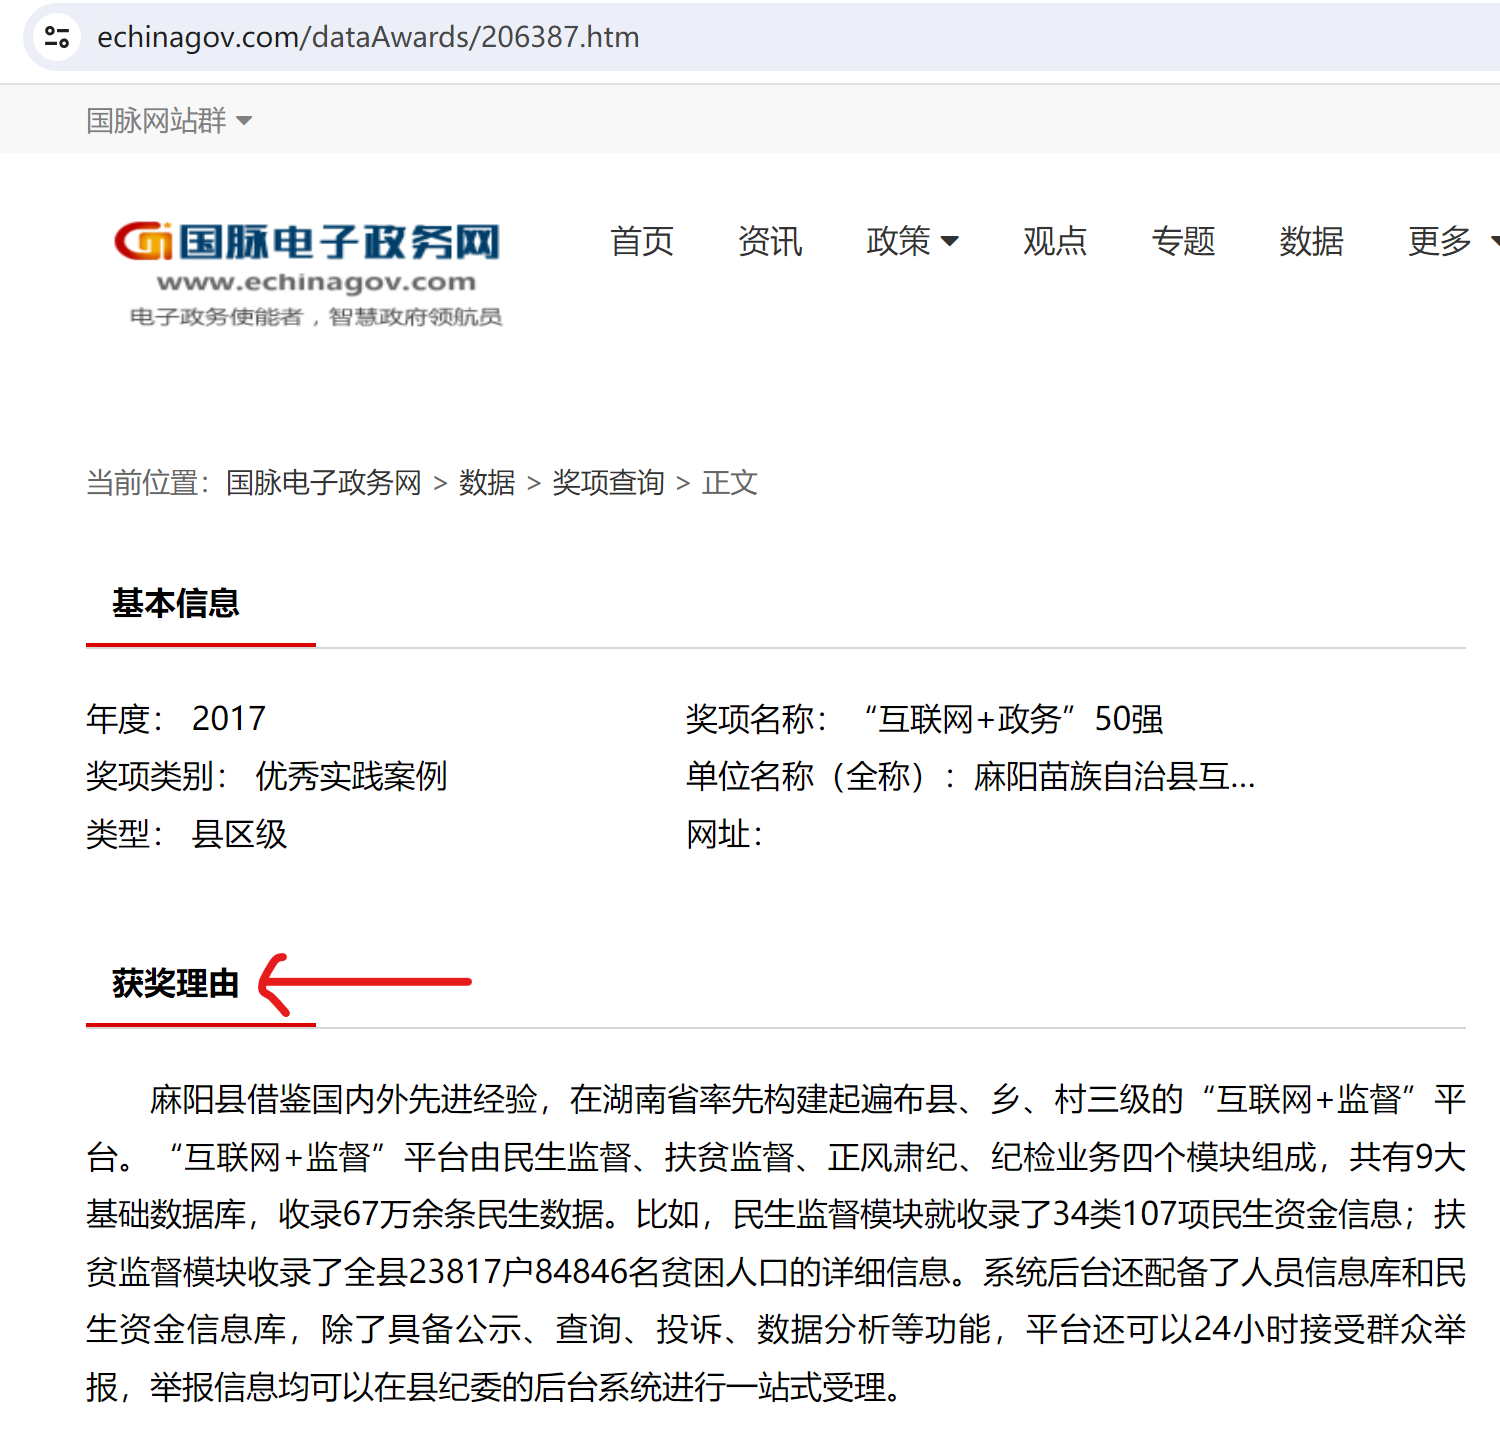

下面，我们来尝试提取每一个得奖网站的获奖理由：

In [121]:
url_test2 = "https://www.echinagov.com/dataAwards/206387.htm"

In [132]:
test2 = getHtml(url_test2)

In [133]:
# 借助Xpath Helper，识别要爬取内容的Xpath路径
web2 = etree.HTML(test2).xpath("/html/body/div[@class='main wrap clearfix']/div[@class='content-left-wapper l']/div[@class='sidebar basic-msg pb30']/p") 

In [134]:
web2[0].text

'麻阳县借鉴国内外先进经验，在湖南省率先构建起遍布县、乡、村三级的“互联网+监督”平台。“互联网+监督”平台由民生监督、扶贫监督、正风肃纪、纪检业务四个模块组成，共有9大基础数据库，收录67万余条民生数据。比如，民生监督模块就收录了34类107项民生资金信息；扶贫监督模块收录了全县23817户84846名贫困人口的详细信息。系统后台还配备了人员信息库和民生资金信息库，除了具备公示、查询、投诉、数据分析等功能，平台还可以24小时接受群众举报，举报信息均可以在县纪委的后台系统进行一站式受理。'

稳妥起见，我们再试试其他网页

In [28]:
url_test3 = "https://www.echinagov.com/dataAwards/206386.htm"
# url_test3 = 'https://www.echinagov.com/dataAwards/177750.htm'

In [29]:
web3 = etree.HTML(getHtml(url_test3)).xpath("/html/body/div[@class='main wrap clearfix']/div[@class='content-left-wapper l']/div[@class='sidebar basic-msg pb30']/p") 

In [30]:
web3[0].text

'黑龙江“互联网+公安政务服务”平台采用了集群架构设计，集成资讯、办事、互动、服务等功能，初步形成了“一大平台全网贯通、三级联动全警应用、六大载体全面支持、七大中心全网贯通、八大功能全程服务”总体功能架构。即：把原户政、交警、出入境等13个警种服务平台整合“平台”中，能上网即上网，实现融合共享；打破了层级、业务和时空限制，实现了省市县三级公安机关上线应用、联动运行；支持了门户网站、电脑客户端、手机APP、微信、平板电脑、终端大屏“六大”终端应用方式；设立了“办事中心、诉求中心、查询中心、下载中心、帮助中心、便民中心、个人中心”七大中心；集成了“网上公示、网上咨询、网上办事、网上监督、网上互动、网上宣传、网上评警和网上邮递”八大功能。'

没有问题！

所有步骤都没有问题，下面就是如何把上述所有小部分整合成一个大部分了。

**正式爬虫：集成的核心代码**

In [1]:
# 导入库
import random
import requests
import json
import pandas as pd
from bs4 import BeautifulSoup
from lxml import etree

# 动态进度
from tqdm import tqdm

# 隐藏warning提示
import warnings
warnings.filterwarnings("ignore")

# 定义基本爬虫request框架
from retrying import retry
@retry(stop_max_attempt_number=2000)
def getHtml(url):
    user_agent = random.choice(USER_AGENTS)
    headers = {
        "Host":"www.echinagov.com",
        'User-Agent': user_agent
    }
    try:
        response = requests.get(url, headers=headers)
        response.encoding = response.apparent_encoding
        #print(response.url)
        text = response.text
        return text
    except:
        print("爬取失败!")
        raise Exception("爬取失败，重试...")

USER_AGENTS = [
    "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36",
    "Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.75.14 (KHTML, like Gecko) Version/7.0.3 Safari/537.75.14",
    "Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.2; Win64; x64; Trident/6.0)",
    'Mozilla/5.0 (Windows; U; Windows NT 5.1; it; rv:1.8.1.11) Gecko/20071127 Firefox/2.0.0.11',
    'Opera/9.25 (Windows NT 5.1; U; en)',
    'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1; .NET CLR 1.1.4322; .NET CLR 2.0.50727)',
    'Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.5 (like Gecko) (Kubuntu)',
    'Mozilla/5.0 (X11; U; Linux i686; en-US; rv:1.8.0.12) Gecko/20070731 Ubuntu/dapper-security Firefox/1.5.0.12',
    'Lynx/2.8.5rel.1 libwww-FM/2.14 SSL-MM/1.4.1 GNUTLS/1.2.9',
    "Mozilla/5.0 (X11; Linux i686) AppleWebKit/535.7 (KHTML, like Gecko) Ubuntu/11.04 Chromium/16.0.912.77 Chrome/16.0.912.77 Safari/535.7",
    "Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:10.0) Gecko/20100101 Firefox/10.0 "
]

# 定义数据清洗函数
def ls2df(ls,column_num:int,column_names=[]):
    '''
    input
    ------
    ls: a list with format like ['a1','a2','a3','b1','b2','b3',...]
    column_num: the number of column of your table
    column_names: the name of column of your table
    '''
    import pandas as pd
    if len(ls)%column_num==0:
        if column_names==[]:
            df = pd.DataFrame()
            for i in range(column_num):
                df['col'+str(i)] = [ls[j] for j in range(i,len(ls),column_num)]
            return df
        else:
            if column_num==len(column_names):
                df = pd.DataFrame()
                for i in range(column_num):
                    df[column_names[i]] = [ls[j] for j in range(i,len(ls),column_num)]
                return df
            else:
                print("Error!!\nThe numbers of columan and its name are not matched!")
    else:
        print("Error!!\nThe structure of table is wrong!")
        
# 基本网址和Xpath解析路径
url_base = "https://www.echinagov.com/awardsSearch?p0=&p1=&page="

xpath4base = "/html/body/div[@class='main wrap']/div[@class='content-bottom-wapper']/ul/li[@class='list-content awards-list-content']/a/span"
xpath4website = "/html/body/div[1]/div[2]/ul/li/a/@href"
xpath4more = "/html/body/div[@class='main wrap clearfix']/div[@class='content-left-wapper l']/div[@class='sidebar basic-msg pb30']/p"

# 结果存储
df_final = pd.DataFrame() 

for page_num in tqdm(range(1,76)):
    # 遍历页码
    url_base_page = url_base+str(page_num)
    
    # 对页面进行爬虫，得到raw html
    base_content = getHtml(url_base_page)
    
    # 利用Xpath提取相关数据
    base_content_extract = etree.HTML(base_content).xpath(xpath4base) # 提取表格内容
    base_content_extract_list = [str(i.text).replace('\r\n',"").replace(' ',"") for i in base_content_extract] # 处理表格内容
    more_content_website_list = etree.HTML(base_content).xpath(xpath4website) # 提取详情网址
    
    # 保存表格内容即详情网址
    df_temp = ls2df(base_content_extract_list,6,['年度','奖项类别','奖项名称','单位名称（全称）','类型','网址'])
    df_temp['详情网址'] = more_content_website_list
    
    # 进一步爬取获奖理由
    more_content = [] # 用于存储获奖理由，生成list格式
    for website_term in more_content_website_list: # 遍历详情网址
        more_content_extract = etree.HTML(getHtml(website_term)).xpath(xpath4more) # 提取获奖理由
        more_content.append(str(more_content_extract[0].text)) # 添加到列表中
    df_temp['获奖理由']=more_content
    
    # 把上述结果进行存储
    df_final = df_final.append(df_temp,ignore_index=True)
    
df_final.to_stata(r"国脉电子政务网获奖名单.dta",write_index=False, version=118)

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [26:50<00:00, 21.48s/it]


In [2]:
df_final

,年度,奖项类别,奖项名称,单位名称（全称）,类型,网址,详情网址,获奖理由
0,2017,优秀实践案例,“互联网+政务”50强,麻阳苗族自治县互联网+监督平台,县区级,None,https://www.echinagov.com/dataAwards/206387.htm,麻阳县借鉴国内外先进经验，在湖南省率先构建起遍布县、乡、村三级的“互联网+监督”平台。“互联...
1,2017,优秀实践案例,“互联网+政务”50强,黑龙江省“互联网+公安政务服务”平台,省级,None,https://www.echinagov.com/dataAwards/206386.htm,黑龙江“互联网+公安政务服务”平台采用了集群架构设计，集成资讯、办事、互动、服务等功能，初步...
2,2017,优秀实践案例,“互联网+政务”50强,大连市出口退税综合服务平台,市级,None,https://www.echinagov.com/dataAwards/206385.htm,大连市出口退税综合服务平台整合了出口退(免)税预审核、正式申报、结果反馈，认证发票、业务数据...
3,2017,优秀实践案例,“互联网+政务”50强,辽源市“无缝式”政务服务模式,市级,None,https://www.echinagov.com/dataAwards/206384.htm,辽源市人民政府网站以用户需求和使用体验为出发点，针对市民百姓日益增长的咨询获取、信息查询、网...
4,2017,优秀实践案例,“互联网+政务”50强,吉林省网上办事大厅,省级,None,https://www.echinagov.com/dataAwards/206383.htm,吉林省网上办事大厅是吉林政务服务“一张网”的办事服务门户，为个人和法人提供覆盖省市县三级的3...
...,...,...,...,...,...,...,...,...
737,2005,政务公开,“本地概览”特别奖,浙江省人民政府门户网站,省级,http://www.zhejiang.gov.cn/,https://www.echinagov.com/dataAwards/49634.htm,在浙江概览中，通过省情概要、浙江地市、浙江地图及 招商引资等栏目完整的介绍浙江省及浙...
738,2005,政务公开,“机构介绍”特别奖,大连市人民政府门户网站,市级,http://www.dl.gov.cn/gov/,https://www.echinagov.com/dataAwards/49608.htm,改版后的“中国·大连”不但从网站规划到栏目定位，均有了不少的突破，主要突出了政务和服...
739,2007,综合创新,综合创新大奖,国家商务部政府门户网站,部委,http://www.mof.gov.cn/index.htm,https://www.echinagov.com/dataAwards/49593.htm,一、政务信息公开，稳步推进“透明”政府建设。
740,2005,政务公开,“领导介绍”特别奖,浙江省人民政府门户网站,省级,http://www.zhejiang.gov.cn/,https://www.echinagov.com/dataAwards/49590.htm,在政府门户网站上向社会公开政府领导的行政分工，是建设“透明政府”的必要环节，彰显政...
